# Signal Processing (SP)

In the following, we are going to show you an example of how to manipulate the (simulated) continuous time signal.



In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Generating the sinusoid signal

In the first step, we are going to generate a simple sinusoid signal for further analyzing.

$x(t) = A_1 sin(2\pi f_1 t) + A_2 sin(2\pi f_2 t)$,
for $0 \leq t \leq 6$, 

elsewise $x(t) = 0$,

where $(f_1, A_1)=(1,10)$, $(f_2, A_2)=(8,2)$

From the above equation, it is obvious that the signal is consisted of two different sinusoid signals. The first one is a signal whose frequency is 1 Hz and amplitude is 10. The other one is a signal whose frequency and amplitude are 8 Hz and 2. We suppose the signal is composed of a major signal and a perturbation, that is aimed for deleting.

In [2]:
def signal(ts, f1=1, a1=10, f2=8, a2=2, eps=1e-6):
  if ts >= 0.0 and ts <= 6.0:
    return a1 * np.sin(2 * np.pi * f1 * ts) + a2 * np.sin(2 * np.pi * f2 * ts)
  else:
    return 0.0

**In the modern digital system, the continuous signal is approximately approaching by a group of pieces of discrete signal**. In the following, we split the time by 0.005 second.

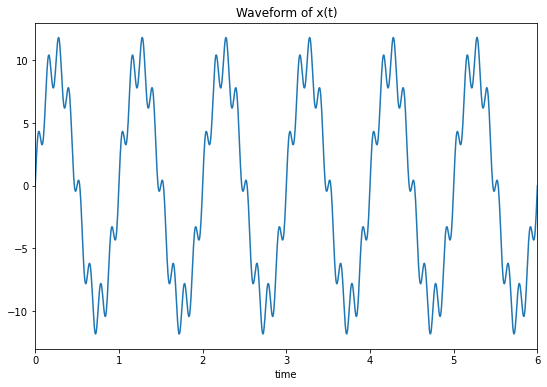

In [3]:
dt = 0.005

times = np.linspace(0.0, 6.0, num=int(6./dt))
x_t = [signal(t) for t in times]

plt.figure(figsize=(9, 6))
plt.plot(times, x_t)
plt.title("Waveform of x(t)")
plt.xlabel("time")
plt.xlim((0., 6.))
plt.show()

You can find out there is a major signal within it, but a distrubed signal also exists (8 Hz).

In [4]:
assert len(x_t) == len(times)
len(x_t)

1200

## CTFT for analyzing the components of the signal

Next, we start analyzing the signal we just created. The first step is to transform the signal by time scope into the frequency scope. Such operation is achieved by continuous time fourier transform. The mathematical definition is the following.

$V(f) = \int^\infty_{-\infty}v(t)e^{-j2{\pi}ft}dt$

The basic idea to transform the signal by time scope into the frequency scope is to test every sub-frequency. Here we split the frequency by 0.005 from -10Hz to 10Hz. Then taking the sub-frequency to the fourier transform with the time-scoped signal.

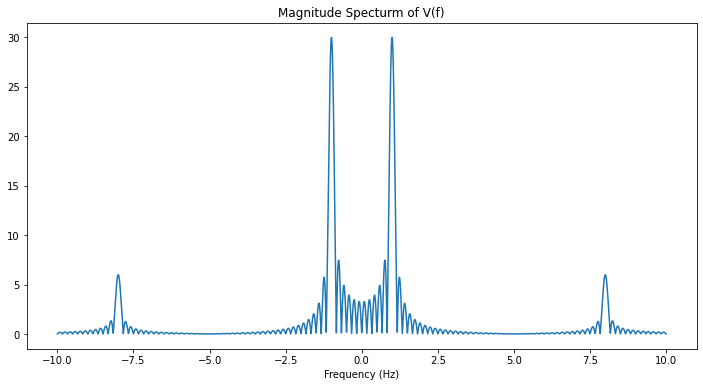

In [5]:
def ctft(freq, ts_sigs, tss, dt):
  integral_val = 0.
  for time_idx in range(len(tss)):
    integral_val += ts_sigs[time_idx] * np.exp(-2j*np.pi*freq*tss[time_idx]) * dt
  # here, you have to get the length (or absolute value) of the complex
  # to keep the imaginary part of the complex 
  return np.abs(integral_val)

df = 0.005
freqs = np.linspace(-10., 10., int(20./df))
v_f = [ctft(freq, x_t, times, dt) for freq in freqs]

plt.figure(figsize=(12, 6))
plt.plot(freqs, v_f)
plt.title("Magnitude Specturm of V(f)")
plt.xlabel("Frequency (Hz)")
# plt.ylim(0, 35)
plt.show()

From the above result, we can observe there are two main frequencies, 1 Hz and 8 Hz.

## Filtering the frequencies by the frequency spectrum 

From the above frequency specturm, we can find out the complex signal was composed of two different frequencies. We assume the one of high frequency is the noise for removing. We need a low-pass filter to filter out the one of high frequency. We can set the threshold of filtering to the 4 Hz.

## Designing the filter function 

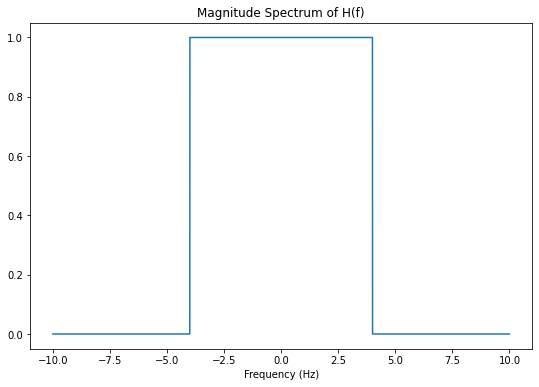

In [6]:
filters = np.linspace(-10., 10., int(20./df))
h_f = np.heaviside(filters+4, 1) - np.heaviside(filters-4, 1)

plt.figure(figsize=(9, 6))
plt.plot(filters, h_f)
plt.xlabel("Frequency (Hz)")
plt.title("Magnitude Spectrum of H(f)")
plt.show()

From the above filtering signal, if we multiply the filtering signal ($H(f)$) with the CTFT-calculated signal ($V(f)$), it would leave the major signal (~ 1 Hz) only.

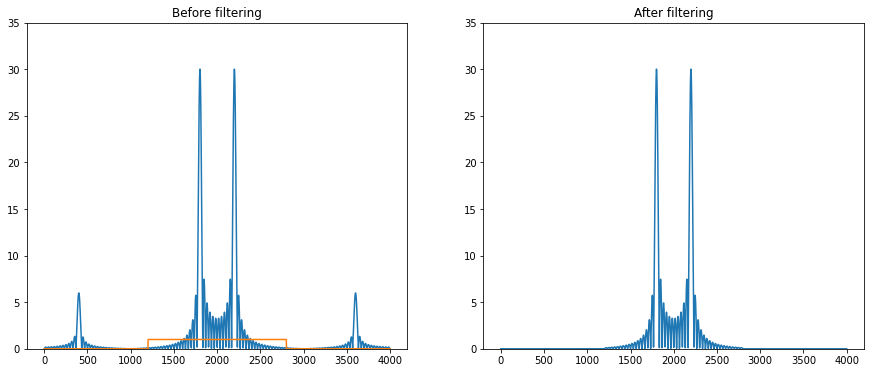

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].plot(v_f)
ax[0].plot(h_f)
ax[0].set_ylim((0, 35))
ax[0].set_title("Before filtering")

ax[1].plot(v_f * h_f)
ax[1].set_ylim((0, 35))
ax[1].set_title("After filtering")
plt.show()

From the above multiplication, we can find out that the filter removed the nosie part from the origin signal. Now let's conduct an inverse CTFT (a.k.a. iCTFT) operation to convert the frequency domain back to the time domain of the filter.

$v(t)=\int^\infty_{-\infty}V(f)e^{j2{\pi}ft}df$

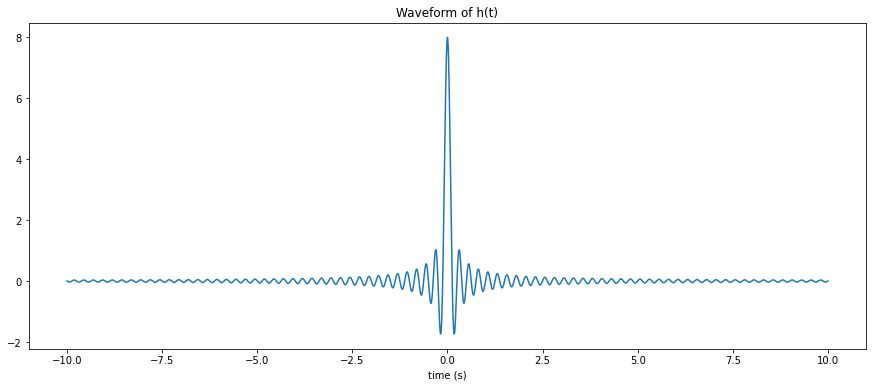

In [8]:
def ictft(times, freq_sigs, freqs, df):
  time_sigs = 0.
  for freq_idx in range(len(freq_sigs)):
    time_sigs += freq_sigs[freq_idx] * np.exp(2j*np.pi*freqs[freq_idx]*times) * df
  # here we only keep the real part of complex, it is helpful for filtering 
  return time_sigs.real
  # return np.abs(time_sigs)

h_t = [ictft(t, h_f, filters, df) for t in filters]

plt.figure(figsize=(15, 6))
plt.plot(filters, h_t)
plt.title("Waveform of h(t)")
plt.xlabel("time (s)")
plt.show()

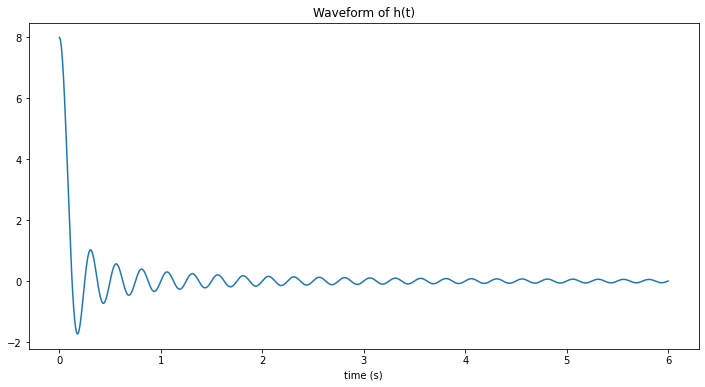

In [9]:
h_ht = [ictft(t, h_f, filters, df) for t in times]

plt.figure(figsize=(12, 6))
plt.plot(times, h_ht)
plt.title("Waveform of h(t)")
plt.xlabel("time (s)")
plt.show()

## Convolution multiplication between x(t) and h(t)

The multiplication of the frequency domain is equal to the convolution multiplication of the time domain, that is, $y(t) = x(t) * h(t)$. After the convolution, you will get the filtered signal.

$y(t)=h(t)*x(t) = \int^\infty_{\tau=-\infty}h(\tau)x(t-\tau)d\tau=\int^\infty_{\tau=-\infty}x(\tau)h(t-\tau)d\tau$

or to the discrete signal as well as to the digital system,

$y[n] = h[n] * x[n] = \sum^\infty_{k=-\infty}h[k]x[n-k]=\sum^\infty_{k=-\infty}x[k]h[n-k]$

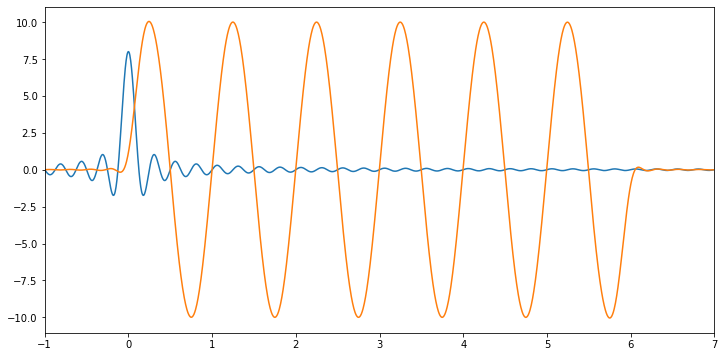

In [10]:
filtered_sigs = []
dtau = df

for filter_idx in range(len(filters)):
  sigs = 0.
  for x_idx in range(len(x_t)):
    if filter_idx - x_idx > -1: 
      sigs += h_t[filter_idx-x_idx] * x_t[x_idx] * df
    else:
      break
  filtered_sigs.append(sigs)

plt.figure(figsize=(12, 6))
plt.plot(filters, h_t)
plt.plot(filters, filtered_sigs)
plt.xlim((-1, 7))
plt.show()

## Re-validate the filtered signal

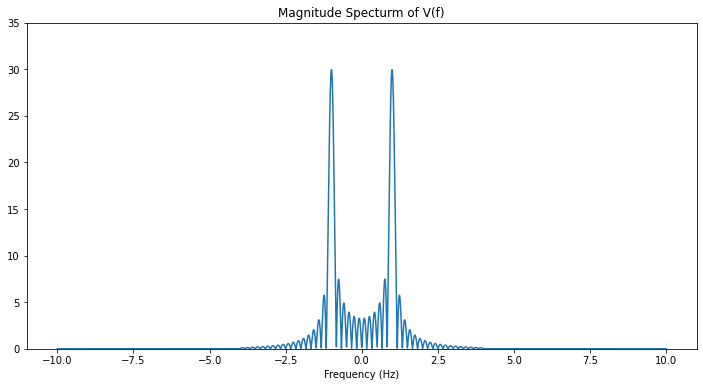

In [11]:
val_times = filters
val_v_f = [ctft(freq, filtered_sigs, val_times, dt) for freq in freqs]

plt.figure(figsize=(12, 6))
plt.plot(val_times, val_v_f)
plt.title("Magnitude Specturm of V(f)")
plt.xlabel("Frequency (Hz)")
plt.ylim(0, 35)
plt.show()

# Fast Fourier Transform (FFT) via Numpy

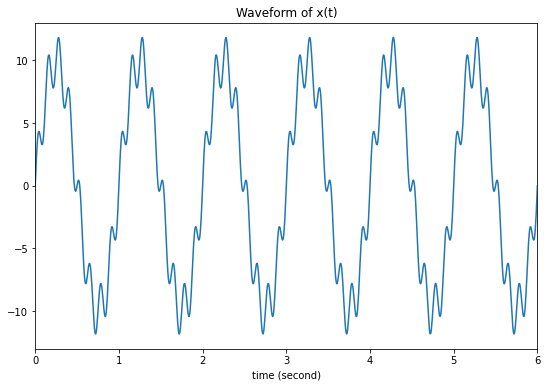

In [12]:
plt.figure(figsize=(9, 6))
plt.plot(times, x_t)
plt.title("Waveform of x(t)")
plt.xlabel("time (second)")
plt.xlim((0., 6.))
plt.show()

In [13]:
N = len(x_t)
fs = 1 / dt

print("Number of DFT: {}".format(N))
print("The sampling rate on the time domain: {}".format(fs))

Number of DFT: 1200
The sampling rate on the time domain: 200.0


## Creating all necessary frequencies

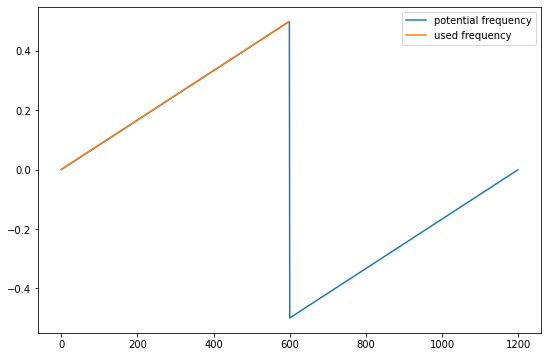

In [14]:
raw_freqs = np.fft.fftfreq(len(x_t))

# for power spectra
# ignoring half the values, as they are the conjugates of the other
mask = raw_freqs > 0

plt.figure(figsize=(9, 6))
plt.plot(raw_freqs, label="potential frequency")
plt.plot(raw_freqs[mask], label="used frequency")
plt.legend()
plt.show()

## Fast Fourier Transform

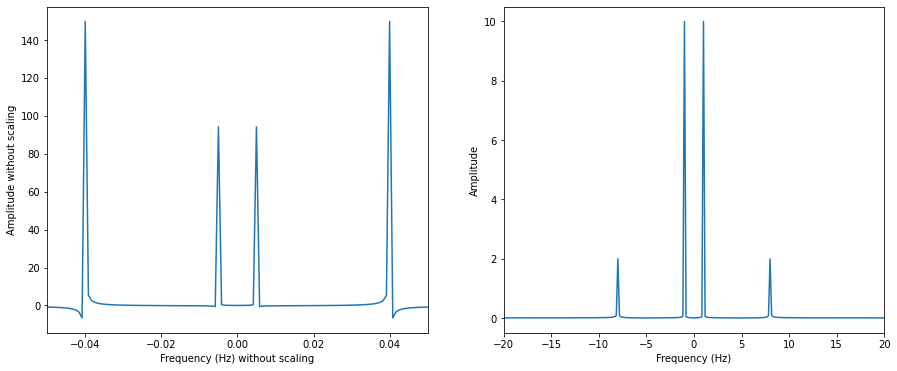

In [15]:
X_f = np.fft.fft(x_t)

# to shift the frequency region [0, ts) to (-fs/2, fs/2]
# making the 0 Hz at the center of the frequency spectrum
X_f = np.fft.fftshift(X_f)

# abs() for both real and imag parts
# (N / 2): for only one part
X_f_amplitude = np.abs(X_f) / (N / 2)

f_axis = np.fft.fftfreq(N)
fs_axis = np.fft.fftshift(f_axis) * fs

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].plot(np.fft.fftshift(f_axis), X_f.real)
ax[0].set_xlim((-0.05, 0.05))
ax[0].set_xlabel("Frequency (Hz) without scaling")
ax[0].set_ylabel("Amplitude without scaling")

ax[1].plot(fs_axis, X_f_amplitude)
ax[1].set_xlim((-20, 20))
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("Amplitude")
plt.show()

Let's look at the signal again.

$x(t) = A_1 sin(2\pi f_1 t) + A_2 sin(2\pi f_2 t)$,
for $0 \leq t \leq 6$, 

elsewise $x(t) = 0$,

where $(f_1, A_1)=(1,10)$, $(f_2, A_2)=(8,2)$

To the left-handed image, you should see each paif of the amplitude and the freqency. To the frequency, there exist two major signals. From the formula,

$F_1=\frac{2\pi{f_1}}{T} = \frac{2*3.14*1}{1200} = 0.005235987755982988$,  \
$F_2=\frac{2\pi{f_2}}{T} = \frac{2*3.14*8}{1200} = 0.041887902047863905$

Here, $T$ is the number of the time points.

To the right-handed image, it is obvious that two peaks match the two sinusoid signals, including the frquency and the amplitude.

## Designing the low-pass frequency filter

In [16]:
from scipy.signal import argrelextrema

In [17]:
local_maxima_idx = argrelextrema(X_f_amplitude, np.greater)[0]
fs_masked = list(range(int(len(fs_axis)/2), int(len(fs_axis))))
used_idx = local_maxima_idx[int(len(local_maxima_idx)/2):] - int(N/2)
used_fs = fs_axis[fs_masked][used_idx]
print("Frequency components: {}".format(used_fs))

Frequency components: [1. 8.]


It is obvious filtering the frequency of 8 Hz.

In [18]:
local_maxima_idx, fs_axis[local_maxima_idx]

(array([552, 594, 606, 648]), array([-8., -1.,  1.,  8.]))

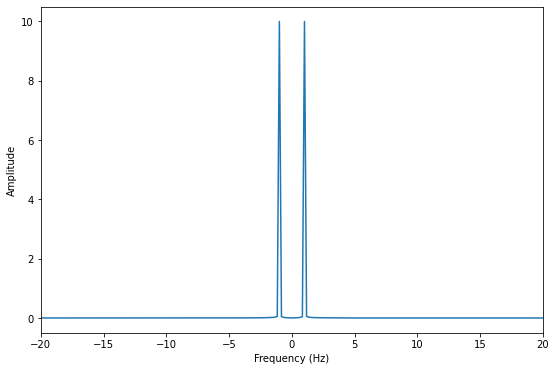

In [19]:
filtered_X_f = X_f.copy()
filtered_X_f[0:int((552 + 594) / 2)] = 0
filtered_X_f[int((606 + 648) / 2):] = 0

plt.figure(figsize=(9, 6))
plt.plot(fs_axis, np.abs(filtered_X_f) / 600)
plt.xlim((-20, 20))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.show()

## Rebuilding the signal via iDFT

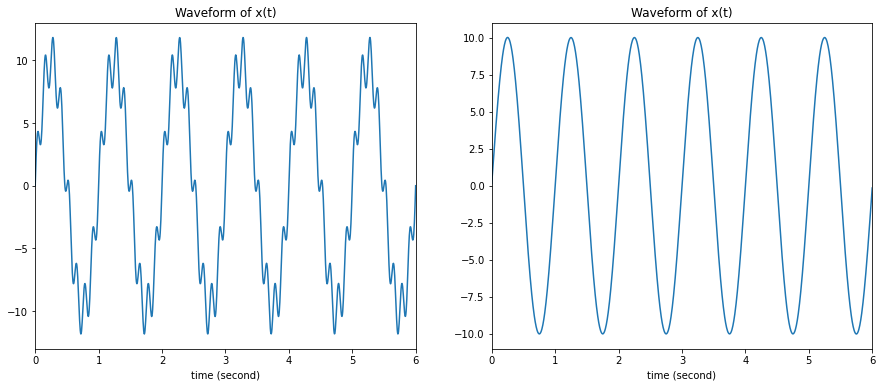

In [20]:
# reset the time series [-ts/2, ts/2] to [0, ts]
v_t = np.fft.ifft(np.fft.fftshift(filtered_X_f))

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].plot(times, x_t)
ax[0].set_title("Waveform of x(t)")
ax[0].set_xlabel("time (second)")
ax[0].set_xlim((0., 6.))

# basically the rebulding signal is only for the real part,
# however, there is a bit nosie to the imag part 
ax[1].plot(times, v_t.real)
ax[1].set_title("Waveform of x(t)")
ax[1].set_xlabel("time (second)")
ax[1].set_xlim((0., 6.))
plt.show()

# FFT Applications

## Convolutions of Same Length Signals

In [21]:
def ConvByFFT(u, v):
  tlen = len(u) + len(v) - 1
  u_ = u + np.zeros(tlen - len(u)).astype(np.int).tolist()
  v_ = v + np.zeros(tlen - len(v)).astype(np.int).tolist()
  return np.fft.ifft(np.multiply(np.fft.fft(u_), np.fft.fft(v_)))

In [22]:
u = [1,2,3,4,5]
v = [10,20,30]
# {u * v} = [10, 40, 100, 160, 220, 220, 150]

ConvByFFT(u, v).real

array([ 10.,  40., 100., 160., 220., 220., 150.])

## Polynomial Multiplication

$(1-3x^2+4x^3)(2+4x^2-5x^8)=2-2x^2+8x^3-12x^4+16x^5-5x^8+15x^{10}-20x^{11}$

In [23]:
a = [1, 0, -3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
b = [2, 0, 4, 0, 0, 0, 0, 0, -5, 0, 0, 0, 0, 0, 0, 0, 0]

# np.set_printoptions(suppress=True)
result = np.fft.ifft(np.multiply(np.fft.fft(a), np.fft.fft(b))).real
parameters = result.tolist()
parameters

[1.9999999999999991,
 1.2538989454590002e-15,
 -2.0000000000000004,
 8.0,
 -12.0,
 16.0,
 0.0,
 1.6718652606120004e-15,
 -5.000000000000001,
 -8.359326303060002e-16,
 14.999999999999998,
 -20.0,
 -3.343730521224001e-15,
 8.359326303060002e-16,
 0.0,
 -4.179663151530001e-16,
 2.9257642060710006e-15]

In [24]:
def Polynomial(x):
  return (1-3*(x**2)+4*(x**3)) * (2+4*(x**2)-5*(x**8))

def BuildPolynomial(parameters):
  def build(x):
    sum = 0
    for i in range(len(parameters)):
      sum += parameters[i] * (x ** i)
    return sum
  return build

In [25]:
x = 1.5
polynomial = BuildPolynomial(parameters)
print(polynomial(x), Polynomial(x))

-907.8701171874987 -907.8701171875
